# CS5950/CS4950 Course Project

This project recaps and systematises work that has been done in the exercise notebooks: if you have worked through the notebooks, little extra work is required.  The aim of the project is to give you the experience of trying to develop a neural network classifier (or regressor), involving setting up a model, optimising the amount of regularisation, investigating its performance, and devising a new model. 

You should do your work in this notebook, filling in the sections below. To do the work, you may re-use code from ***any of the lab-session sheets provided so far***. (In fact, you should be able to do nearly the entire project using code taken from previous lab sessions.) 

Please complete this workbook and submit it on Moodle, with all outputs (numbers and graphs) visible and included. 

The deadline for this assignment is **Monday April 3 2023, 10am**

This project has **10%** of the marks of the course.

Please write your student number **101020667**  
so that I have an identifier of which worksheet I am marking, to prevent any confusion! (I have to download your notebooks before marking them, so I don't want to accidentally give credit for your notebook to somebody else...) 

## Set up dataset

You may choose any of the datasets included with Pytorch, or used in the course so far (including, for example, the percolation data). (It is a free country and you may use any other data you wish.)

A safe choice would be either the MNIST data or the MNIST-fashion data, which is a drop-in replacement for MNIST (same size data format, same number of classes, same number of training and test examples). 

A more interesting choice would be CIFAR-10

In setting up the data, you should set up a training set and a test set. The test set should be large enough to give a reasonably accurate assessment of the error-rate (or loss) of your models: preferably at least 10,000 examples.

For the learning curve experiment (below), you will need to construct training sets of different sizes, with the largest at least 10 times the smallest. For the MNIST data, for example, your smallest training set might be 500, with sizes 500, 1000, 2000, 4000, 8000, 16000, 32000, and perhaps 60000 if you have time. (You get no extra marks for doing very long experiments.) 

## Set up model 

Set up a Pytorch model (you may find it helpful to keep it simple and fast to train). Train on an intermediate-sized dataset (if you are using MNIST, say 2000 or 4000). 


Plot the loss and error rate as a function of training epochs. 


##  1.  Assessment of initial model:    ***12 marks***

Ensure that your model is complex enough to *overfit* the training data: that is the loss/error-rate on the training set should be below your target loss/error-rate, and the loss/error-rate on the validation set should be higher than this (preferably higher than your target error-rate). 

**Ans.**

In [41]:
# Keeping all our imports in one introductary section
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch.nn.functional as F
import torch.optim as optim
import math
import time
from torchvision import datasets

In [44]:
#Define Transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.0], std=[1.0,])])
# Load the CIFAR-10 dataset
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform= transform)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform= transform)

#extracting mini batches from large dataset
trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
loss_function = nn.CrossEntropyLoss()

## The CIFAR-10 dataset ##
The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

Here are the classes in the dataset, as well as 10 random images from each :

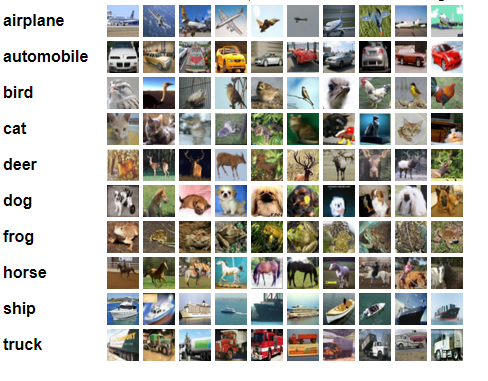

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

<b>Reference :</b> https://www.cs.toronto.edu/~kriz/cifar.html

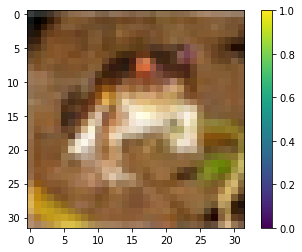

-------------------------------------------------------
label :  6  Category :  frog
-------------------------------------------------------


In [18]:
# Get an example image and label from the dataset
image, label = cifar_trainset[0]

# Resize the image to 32x32 pixels
image = F.interpolate(image.unsqueeze(0), size= 32, mode='bilinear', align_corners=True).squeeze(0)

label_reference = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
# Convert the image to a numpy array and display it
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.colorbar()
plt.show()
print ('-------------------------------------------------------')
print('label : ',label, ' Category : ', label_reference[label])
print ('-------------------------------------------------------')

In [8]:
class SimpleLinearNN(nn.Module):
    def __init__(self):
        super(SimpleLinearNN, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [16]:
nn1 = SimpleLinearNN()
optimizer1 = optim.RMSprop(nn1.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()

train_losses = []
train_errors = []

start = time.time() # Keeping track of how long it takes to train our linear network
print ('============================================================')
print('               Training Loss and Error Rate')
print ('============================================================')
for epoch in range(20): # number of times to loop over the dataset
    current_loss = 0.0 
    n_mini_batches = 0
    n_correct = 0
    n_total = 0
    
    for i, mini_batch in enumerate(trainloader, 0): # Each Loop takes care of training the Network over Train Dataset Once
        images, labels = mini_batch
        
        optimizer1.zero_grad()
        
        outputs = nn1(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer1.step()
        
        n_mini_batches += 1 
        current_loss += loss.item()
        
        # Compute number of correct predictions
        predictions = torch.argmax(outputs, dim=1)
        n_correct += torch.sum(predictions == labels).item()
        n_total += labels.shape[0]
        
    # Compute error rate and append to errors list
    error_rate = 1 - n_correct / n_total
    train_errors.append(error_rate)
     
    # Compute average loss and append to losses list
    avg_loss = current_loss / n_mini_batches
    train_losses.append(avg_loss)
    
    

    print('Epoch %d || loss: %.3f || error rate: %.3f' %(epoch+1, avg_loss, error_rate))
    print('------------------------------------------------------------')

end = time.time()
print ('============================================================')
exec_time = end - start 
print('Total Time Taken to Train Linear Model on 20 Epochs : %.2f' %exec_time)
print ('============================================================')

               Training Loss and Error Rate
Epoch 1 - loss: 1.942 - error rate: 0.704
------------------------------------------------------------
Epoch 2 - loss: 1.771 - error rate: 0.635
------------------------------------------------------------
Epoch 3 - loss: 1.689 - error rate: 0.605
------------------------------------------------------------
Epoch 4 - loss: 1.631 - error rate: 0.582
------------------------------------------------------------
Epoch 5 - loss: 1.585 - error rate: 0.564
------------------------------------------------------------
Epoch 6 - loss: 1.543 - error rate: 0.549
------------------------------------------------------------
Epoch 7 - loss: 1.508 - error rate: 0.535
------------------------------------------------------------
Epoch 8 - loss: 1.480 - error rate: 0.527
------------------------------------------------------------
Epoch 9 - loss: 1.456 - error rate: 0.517
------------------------------------------------------------
Epoch 10 - loss: 1.428 - erro

In [19]:
nn1 = SimpleLinearNN()
optimizer1 = optim.RMSprop(nn1.parameters(), lr=0.0001)

test_losses = []
test_errors = []
start = time.time() # Keeping track of how long it takes to test our linear network
print ('============================================================')
print('               Testing Loss and Error Rate')
print ('============================================================')
for epoch in range(20): # number of times to loop over the dataset
    current_loss = 0.0 
    n_mini_batches = 0
    n_correct = 0
    n_total = 0
    
    for i, mini_batch in enumerate(testloader, 0): # Each Loop takes care of training the Network over Test Dataset Once
        images, labels = mini_batch
        
        optimizer1.zero_grad()
        
        outputs = nn1(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer1.step()
        
        n_mini_batches += 1 
        current_loss += loss.item()
        
        # Compute number of correct predictions
        predictions = torch.argmax(outputs, dim=1)
        n_correct += torch.sum(predictions == labels).item()
        n_total += labels.shape[0]
        
    # Compute error rate and append to errors list
    error_rate = 1 - n_correct / n_total
    test_errors.append(error_rate)
     
    # Compute average loss and append to losses list
    avg_loss = current_loss / n_mini_batches
    test_losses.append(avg_loss)
     
    print('Epoch %d || loss: %.3f || error rate: %.3f' %(epoch+1, avg_loss, error_rate))
    print('------------------------------------------------------------')

end = time.time()
print ('============================================================')
exec_time = end - start 
print('Total Time Taken to Test Linear Model on 20 Epochs : %.2f' %exec_time)
print ('============================================================')

               Testing Loss and Error Rate
Epoch 1 - loss: 2.119 - error rate: 0.782
------------------------------------------------------------
Epoch 2 - loss: 1.964 - error rate: 0.710
------------------------------------------------------------
Epoch 3 - loss: 1.908 - error rate: 0.684
------------------------------------------------------------
Epoch 4 - loss: 1.868 - error rate: 0.667
------------------------------------------------------------
Epoch 5 - loss: 1.833 - error rate: 0.652
------------------------------------------------------------
Epoch 6 - loss: 1.802 - error rate: 0.640
------------------------------------------------------------
Epoch 7 - loss: 1.772 - error rate: 0.628
------------------------------------------------------------
Epoch 8 - loss: 1.745 - error rate: 0.621
------------------------------------------------------------
Epoch 9 - loss: 1.719 - error rate: 0.613
------------------------------------------------------------
Epoch 10 - loss: 1.696 - error

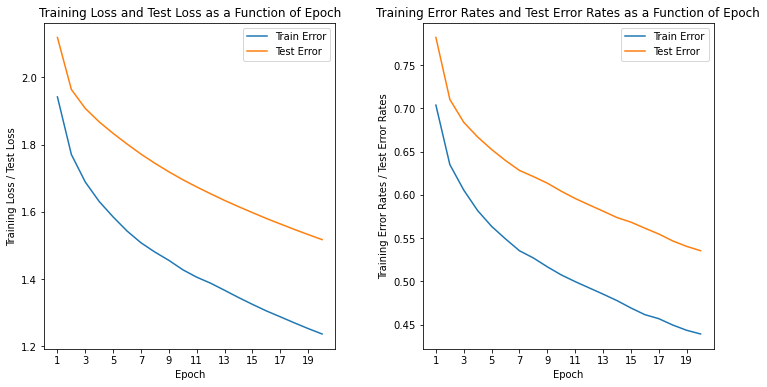

In [25]:
# Plot the training loss and error rate as a function of training epochs
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), train_losses)
plt.plot(range(1, 21), test_losses)
plt.xticks(range(1, 21, 2))  # set x-ticks at every 2 interval
plt.xlabel('Epoch')
plt.ylabel('Training Loss / Test Loss')
plt.title('Training Loss and Test Loss as a Function of Epoch')
plt.legend(['Train Error','Test Error'])

# Plot the training loss and error rate as a function of training epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, 21), train_errors)
plt.plot(range(1, 21), test_errors)
plt.xticks(range(1, 21, 2))  # set x-ticks at every 2 interval
plt.xlabel('Epoch')
plt.ylabel('Training Error Rates / Test Error Rates')
plt.title('Training Error Rates and Test Error Rates as a Function of Epoch')
plt.legend(['Train Error','Test Error'])

plt.subplots_adjust(wspace=0.3) # adjust the horizontal space between the subplots
plt.gcf().set_size_inches(12, 6) # set the size of the figure
plt.show()

**Regarding Loss and Error Rates in CIFAR 10 Datasets:**

"CIFAR-10 is a well-understood dataset and widely used for benchmarking computer vision algorithms in the field of machine learning".(<b> Reference : </b> https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/#:~:text=CIFAR%2D10%20is%20a%20well,to%20achieve%2080%25%20classification%20accuracy.). It is acceptable to say that CIFAR 10 is much more difficult a dataset to handle, rather than MNIST and the reported accuracy of CIFAR 10 should be high on Convolutional Neural Net. It is also important to mention that we are training the model for only a mere **20 Epochs** for the sake of our limited resources and just to prove our points asked to prove in the projects. The accuracy can improve much more if we train the model longer,i.e we have not reached our model accuracy saturation yet.  Here, in question 1, 2 and 3 we are using Linear Neural Net just to set up a contrast on how much better a proper CNN model can be in performance than a simple linear network.

Regarding the amount of Loss and Error Rate still suffered by our Linear Model, I would say it is quite satisfactory for a Linear NN to achieve on CIFAR 10. The model takes **362.35 sec** to **process the trainloader** and **67.41 sec** to **process the testloader** data. The final **training loss and error rates are : loss: 1.236, error rate: 0.439** and **testing loss and error rates are :  loss: 1.517, error rate: 0.535**. Clearly, we are able to present that our Linear model produces **much better accuracy on trainset, rater than test set**, i.e, we have **overfit our train data.** 

## 2.  Regularisation experiment:  ***12 marks***

Now select a type of regularisation (which may be L2, or dropout) and train your initial model with different amounts of regularisation. 

A small amount of regularisation may improve the validation set performance of your overfitted model; too much regularisation may make performance on the validation set worse. 

Train your model multiple times, applying different amounts of regularisation, and plot a graoph showing the effect of different amounts of regularisation. 

Plot the amount of regularisation along the x axis, and the validation set performance (loss/error-rate) on the y axis.  How does regularisation affect the performance of your initial network, and what is the optimal amount? 

**Ans .** 

We are going to use Dropout Regularization throughout our project.

In [29]:
class SimpleLinearNN_With_Dropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(SimpleLinearNN_With_Dropout, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In this modified Neural Network we have introduced dropout proabability,which- by default in our model- is 0.5.

In [34]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
train_losses = []
test_losses = []

start = time.time() # Keeping track of how long it takes to train our linear network with dropout
print ('=================================================================================================')
print('                                 Training Loss and Error Rate')
print ('=================================================================================================')

for dropout_rate in dropout_rates:
    nn1_dropout = SimpleLinearNN_With_Dropout(dropout_rate=dropout_rate)
    optimizer1_dropout = optim.RMSprop(nn1_dropout.parameters(), lr=0.0001)

    train_loss = 0.0
    test_loss = 0.0
    print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print ('                                     Dropout Rate: ',dropout_rate)
    print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    
    for epoch in range(20):
        # Training loop
        nn1_dropout.train()
        current_loss = 0.0
        n_mini_batches = 0
        for i, mini_batch in enumerate(trainloader, 0):
            images, labels = mini_batch

            optimizer1_dropout.zero_grad()

            outputs = nn1_dropout(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer1_dropout.step()

            n_mini_batches += 1
            current_loss += loss.item()

        avg_loss = current_loss / n_mini_batches
        train_loss = avg_loss

        # Validation loop
        nn1_dropout.eval()
        current_loss = 0.0
        n_mini_batches = 0
        for i, mini_batch in enumerate(testloader, 0):
            images, labels = mini_batch

            outputs = nn1_dropout(images)
            loss = loss_function(outputs, labels)

            n_mini_batches += 1
            current_loss += loss.item()

        avg_loss = current_loss / n_mini_batches
        test_loss = avg_loss
        
        print('Epoch %d || Train Error: %.2f || Test Error: %.2f' %(epoch+1, train_loss, test_loss))
        print('-------------------------------------------------------------------------------------------------')
    train_losses.append(train_loss)
    test_losses.append(test_loss)

end = time.time()
print ('=================================================================================================')
exec_time = end - start 
print('Total Time Taken to Train and Test Linear Model with dropout on 20 Epochs : %.2f' %exec_time)
print ('=================================================================================================')


                                 Training Loss and Error Rate
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                     Dropout Rate:  0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1 || Train loss: 1.95 || Test loss: 1.83
-------------------------------------------------------------------------------------------------
Epoch 2 || Train loss: 1.78 || Test loss: 1.76
-------------------------------------------------------------------------------------------------
Epoch 3 || Train loss: 1.70 || Test loss: 1.69
-------------------------------------------------------------------------------------------------
Epoch 4 || Train loss: 1.64 || Test loss: 1.63
-------------------------------------------------------------------------------------------------
Epoch 5 || Train loss: 1.59 || Test loss: 1.63
-----------------------------------------------------------

Epoch 11 || Train loss: 1.51 || Test loss: 1.50
-------------------------------------------------------------------------------------------------
Epoch 12 || Train loss: 1.49 || Test loss: 1.52
-------------------------------------------------------------------------------------------------
Epoch 13 || Train loss: 1.47 || Test loss: 1.59
-------------------------------------------------------------------------------------------------
Epoch 14 || Train loss: 1.46 || Test loss: 1.45
-------------------------------------------------------------------------------------------------
Epoch 15 || Train loss: 1.44 || Test loss: 1.44
-------------------------------------------------------------------------------------------------
Epoch 16 || Train loss: 1.43 || Test loss: 1.44
-------------------------------------------------------------------------------------------------
Epoch 17 || Train loss: 1.41 || Test loss: 1.41
----------------------------------------------------------------------------

Epoch 3 || Train loss: 1.93 || Test loss: 1.86
-------------------------------------------------------------------------------------------------
Epoch 4 || Train loss: 1.88 || Test loss: 1.82
-------------------------------------------------------------------------------------------------
Epoch 5 || Train loss: 1.85 || Test loss: 1.76
-------------------------------------------------------------------------------------------------
Epoch 6 || Train loss: 1.82 || Test loss: 1.71
-------------------------------------------------------------------------------------------------
Epoch 7 || Train loss: 1.79 || Test loss: 1.70
-------------------------------------------------------------------------------------------------
Epoch 8 || Train loss: 1.77 || Test loss: 1.68
-------------------------------------------------------------------------------------------------
Epoch 9 || Train loss: 1.75 || Test loss: 1.65
-----------------------------------------------------------------------------------

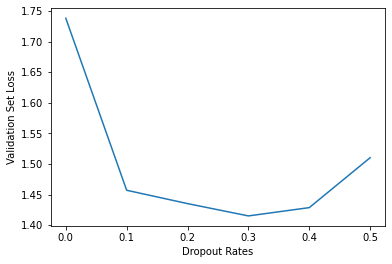

In [35]:
plt.figure()
plt.plot(dropout_rates, test_losses)
plt.xlabel('Dropout Rates')
plt.ylabel('Validation Set Loss')
plt.show()

<b> From the graph, it is clear that the best dropout rate is 0.3 </b>, as the loss is lowest for that drop out.

## 3.  Learning curve experiment:  ***12 marks***

Now train your model (with the amount of regularisation you selected) on different amounts of training data. 

Plot the performance (loss/error-rate) of the model on the validation set against the size of the training set. 
This is typically best done on a log-log plot. 

Describe the approximate relationship between the training set size and loss / error-rate.  Does the network performance appear to improve as some power of the amount of data in the training set?  If so, by what power ? 

For example, a very good rate of improvement is for error-rate to be proportional to $\dfrac{1}{\sqrt{n}}$ where $n$ is the training set size.  For your model, the rate of improvement of validation error with training set size may not be as fast as this (or it may, who knows?)  The aim of this exercise is to find out what it actually is. 

In [8]:
# Create subsets of the CIFAR-10 dataset with varying sizes
trainset_sizes = [1000, 2000, 5000, 10000, 20000, 40000, 50000]

test_errors_subset = []

start = time.time() # Keeping track of how long it takes to train our linear network with dropout
print ('=================================================================================================')
print('                                       Test Error Rate')
print ('=================================================================================================')

for size in trainset_sizes:
    trainset_subset = torch.utils.data.Subset(cifar_trainset, torch.arange(size))
    trainloader_subset = torch.utils.data.DataLoader(trainset_subset, batch_size=64, shuffle=True)

    nn1_dropout = SimpleLinearNN_With_Dropout(dropout_rate=0.3) # Since the best dropout rate was found to be 0.3
    optimizer1_dropout = optim.RMSprop(nn1_dropout.parameters(), lr=0.0001)

    test_errors_dropout = []
    print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print ('                                   Trainset Size: ',size)
    print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    
    for epoch in range(20):
        # Training loop
        nn1_dropout.train()
        current_loss = 0.0
        n_mini_batches = 0
        for i, mini_batch in enumerate(trainloader_subset, 0):
            images, labels = mini_batch

            optimizer1_dropout.zero_grad()

            outputs = nn1_dropout(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer1_dropout.step()

            n_mini_batches += 1
            current_loss += loss.item()

        avg_loss = current_loss / n_mini_batches

        # Validation loop
        nn1_dropout.eval()
        current_loss = 0.0
        n_mini_batches = 0
        n_correct = 0
        n_total = 0
        for i, mini_batch in enumerate(testloader, 0):
            images, labels = mini_batch

            outputs = nn1_dropout(images)
            loss = loss_function(outputs, labels)

            # Compute number of correct predictions
            predictions = torch.argmax(outputs, dim=1)
            n_correct += torch.sum(predictions == labels).item()
            n_total += labels.shape[0]

            n_mini_batches += 1
            current_loss += loss.item()

        error_rate = 1 - n_correct / n_total

        if epoch == 19:
            test_errors_dropout.append(error_rate)

        avg_loss = current_loss / n_mini_batches

        print('Epoch %d || Val error rate: %.3f' %(epoch+1, error_rate))
        print('-------------------------------------------------------------------------------------------------')

    test_errors_subset.append(test_errors_dropout)

end = time.time()
print ('=================================================================================================')
exec_time = end - start 
print('Total Time Taken to Train and Test Linear Model with dropout on 20 Epochs : %.2f' %exec_time)
print ('=================================================================================================')


                                       Test Error Rate
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                   Trainset Size:  1000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1 || Val error rate: 0.873
-------------------------------------------------------------------------------------------------
Epoch 2 || Val error rate: 0.864
-------------------------------------------------------------------------------------------------
Epoch 3 || Val error rate: 0.799
-------------------------------------------------------------------------------------------------
Epoch 4 || Val error rate: 0.799
-------------------------------------------------------------------------------------------------
Epoch 5 || Val error rate: 0.798
-------------------------------------------------------------------------------------------------
Epoch 6 || Val error rate: 0.787
-----

Epoch 16 || Val error rate: 0.663
-------------------------------------------------------------------------------------------------
Epoch 17 || Val error rate: 0.672
-------------------------------------------------------------------------------------------------
Epoch 18 || Val error rate: 0.668
-------------------------------------------------------------------------------------------------
Epoch 19 || Val error rate: 0.649
-------------------------------------------------------------------------------------------------
Epoch 20 || Val error rate: 0.711
-------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                   Trainset Size:  10000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1 || Val error rate: 0.761
------------------------------------------------------

Epoch 13 || Val error rate: 0.536
-------------------------------------------------------------------------------------------------
Epoch 14 || Val error rate: 0.520
-------------------------------------------------------------------------------------------------
Epoch 15 || Val error rate: 0.527
-------------------------------------------------------------------------------------------------
Epoch 16 || Val error rate: 0.527
-------------------------------------------------------------------------------------------------
Epoch 17 || Val error rate: 0.533
-------------------------------------------------------------------------------------------------
Epoch 18 || Val error rate: 0.516
-------------------------------------------------------------------------------------------------
Epoch 19 || Val error rate: 0.518
-------------------------------------------------------------------------------------------------
Epoch 20 || Val error rate: 0.512
------------------------------------------

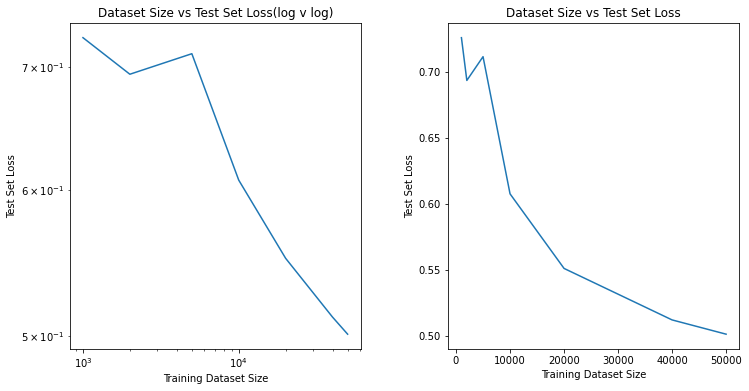

In [9]:
plt.figure()

# THE LOG LOG PLOT
plt.subplot (1,2,1)
plt.xscale('log')
plt.yscale('log')
plt.plot(trainset_sizes, test_errors_subset)
plt.xlabel('Training Dataset Size')
plt.ylabel('Test Set Error')
plt.title('Dataset Size vs Test Set Errors(log v log)')

# JUST COMPARING VALUES DIRECTLY
plt.subplot (1,2,2)
plt.plot(trainset_sizes, test_errors_subset)
plt.xlabel('Training Dataset Size')
plt.ylabel('Test Set Errors')
plt.title('Dataset Size vs Test Set Errors')

plt.subplots_adjust(wspace=0.3) # adjust the horizontal space between the subplots
plt.gcf().set_size_inches(12, 6) # set the size of the figure
plt.show()


<b>So the best training dataset size is set to be 50000</b>, with Test Error Rate calculated to be at **0.501**.

So, before regularization and using best dataset size, our model's **test error rate was 0.535**. At **best dataset size 50000** and **best dropout rate 0.3** , we acheive a **test error rate of 0.535**. So, our model **error rate improves by 6.35% of the original model**. 

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression

# define the train sizes and test errors
train_sizes = [1000, 2000, 5000, 10000, 20000, 40000, 50000]
test_errors = [0.729, 0.7049, 0.6664, 0.5992, 0.5554, 0.5052, 0.5363]

# convert to numpy arrays
train_sizes = np.array(train_sizes).reshape(-1, 1)
test_errors = np.array(test_errors)

# use log of train sizes and test errors
log_train_sizes = np.log10(train_sizes)
log_test_errors = np.log10(1 - test_errors)

# fit a linear regression model
model = LinearRegression()
model.fit(log_train_sizes, log_test_errors)

# extract the slope from the model
slope = model.coef_[0]

print("Slope:", slope)


Slope: 0.15586960068804828


The **slope of the fitted line corresponds to the power of the relationship between the training set size and test accuracy**. If the slope is **negative, it indicates that the network performance improves as the training set size increases.**

The **absolute value of the slope will give you the power by which the performance improves as a function of the training set size. For example, if the slope is -0.5, it indicates that the error rate (100 - test accuracy) is proportional to 1/sqrt(n), where n is the training set size.**

From our calculation, the slope produced by our model is : **0.15586960068804828**. So, our model improves in regards to error rate by a power of almost 0.156 of the dataset size.

## 4. Second model:   *** 14 marks ***

Devise what you believe to be a better neural network architecture for the problem (e.g. for MNIST you might use a fully-connected network for your initial model, and then try a convolutional net for your second model).

Repeat sections 2 (regularisation experiment), and determine whether it has better validation set performance than the first model, for an intermediate size of training set (e.g. 2000 or 4000 for the MNIST data). 

Repeat section 3. Does your model have a different learning curve from the first? Plot the learning curves for the first and second model on the same graph, to compare them. Comment: is there a more rapid reduction of error-rate with training set size for your second model?  

In [20]:
class CNN(nn.Module):
    def __init__(self,dropout_rate=0.5):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(4*4*128, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = x.view(-1, 4*4*128)
        x = self.dropout(self.relu4(self.fc1(x)))
        x = self.fc2(x)
        return x

# Instantiate the model and send it to the device
model = CNN().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [15]:
# Train the model
train_losses_CNN = []
train_errors_CNN = []
test_losses_CNN = []
test_errors_CNN = []

# Define the hyperparameters
num_epochs = 20
batch_size = 100
learning_rate = 0.001

# Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=False)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


for epoch in range(num_epochs):
    running_loss = 0.0
    train_error = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_error += (predicted != labels).sum().item()
    
    train_losses_CNN.append(running_loss / len(train_loader))
    train_errors_CNN.append(train_error / len(train_dataset))

    # Test the model
    model.eval()
    test_loss = 0.0
    test_error = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_error += (predicted != labels).sum().item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    test_losses_CNN.append(test_loss / len(test_loader))
    test_errors_CNN.append(test_error / len(test_dataset))



In [16]:
print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total)) # The size of the loaders are 100 and we are training in 100 iterations, so total no of testing is 10000 which is the test size

Accuracy of the network on the 10000 test images: 73.34 %


<b> Clearly the CNN already performs a lot better on CIFAR 10 than the linear neural network.</b>

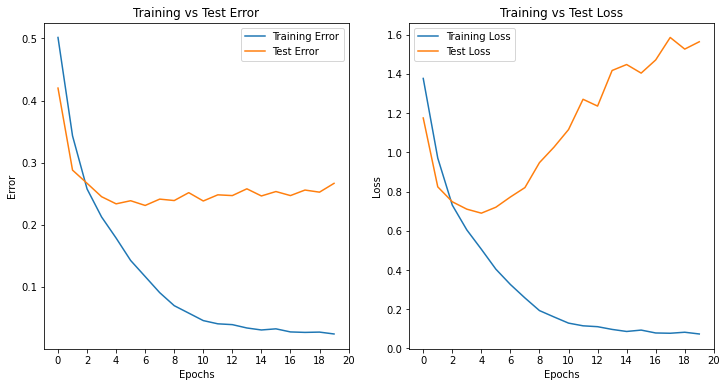

In [17]:
# Plot the training and test errors
plt.figure(figsize=(12, 6))

# Training vs Test Error
plt.subplot(1, 2, 1)
plt.plot(train_errors_CNN, label='Training Error')
plt.plot(test_errors_CNN, label='Test Error')
plt.title('Training vs Test Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.xticks(range(0, num_epochs+1, 2))
plt.legend()

# Training vs Test Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses_CNN, label='Training Loss')
plt.plot(test_losses_CNN, label='Test Loss')
plt.title('Training vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, num_epochs+1, 2))
plt.legend()

plt.show()

## Regularization of CNN

In [22]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
train_losses = []
test_losses = []

start = time.time() # Keeping track of how long it takes to train our linear network with dropout
print ('=================================================================================================')
print('                                 Training Loss and Error Rate')
print ('=================================================================================================')

for dropout_rate in dropout_rates:
    nn1_dropout = CNN(dropout_rate=dropout_rate)
    optimizer1_dropout = optim.RMSprop(nn1_dropout.parameters(), lr=0.0001)

    train_loss = 0.0
    test_loss = 0.0
    print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print ('                                     Dropout Rate: ',dropout_rate)
    print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    
    for epoch in range(20):
        # Training loop
        nn1_dropout.train()
        current_loss = 0.0
        n_mini_batches = 0
        for i, mini_batch in enumerate(trainloader, 0):
            images, labels = mini_batch

            optimizer1_dropout.zero_grad()

            outputs = nn1_dropout(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer1_dropout.step()

            n_mini_batches += 1
            current_loss += loss.item()

        avg_loss = current_loss / n_mini_batches
        train_loss = avg_loss

        # Validation loop
        nn1_dropout.eval()
        current_loss = 0.0
        n_mini_batches = 0
        for i, mini_batch in enumerate(testloader, 0):
            images, labels = mini_batch

            outputs = nn1_dropout(images)
            loss = loss_function(outputs, labels)

            n_mini_batches += 1
            current_loss += loss.item()

        avg_loss = current_loss / n_mini_batches
        test_loss = avg_loss
        
        print('Epoch %d || Train loss: %.2f || Test loss: %.2f' %(epoch+1, train_loss, test_loss))
        print('-------------------------------------------------------------------------------------------------')
    train_losses.append(train_loss)
    test_losses.append(test_loss)

end = time.time()
print ('=================================================================================================')
exec_time = end - start 
print('Total Time Taken to Train and Test Linear Model with dropout on 20 Epochs : %.2f' %exec_time)
print ('=================================================================================================')


                                 Training Loss and Error Rate
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                     Dropout Rate:  0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1 || Train loss: 1.34 || Test loss: 1.20
-------------------------------------------------------------------------------------------------
Epoch 2 || Train loss: 1.01 || Test loss: 1.17
-------------------------------------------------------------------------------------------------
Epoch 3 || Train loss: 0.88 || Test loss: 0.95
-------------------------------------------------------------------------------------------------
Epoch 4 || Train loss: 0.79 || Test loss: 0.94
-------------------------------------------------------------------------------------------------
Epoch 5 || Train loss: 0.72 || Test loss: 0.98
-----------------------------------------------------------

Epoch 11 || Train loss: 0.45 || Test loss: 0.81
-------------------------------------------------------------------------------------------------
Epoch 12 || Train loss: 0.41 || Test loss: 0.95
-------------------------------------------------------------------------------------------------
Epoch 13 || Train loss: 0.38 || Test loss: 1.20
-------------------------------------------------------------------------------------------------
Epoch 14 || Train loss: 0.35 || Test loss: 1.01
-------------------------------------------------------------------------------------------------
Epoch 15 || Train loss: 0.31 || Test loss: 1.09
-------------------------------------------------------------------------------------------------
Epoch 16 || Train loss: 0.29 || Test loss: 1.11
-------------------------------------------------------------------------------------------------
Epoch 17 || Train loss: 0.26 || Test loss: 1.00
----------------------------------------------------------------------------

Epoch 3 || Train loss: 0.98 || Test loss: 0.99
-------------------------------------------------------------------------------------------------
Epoch 4 || Train loss: 0.89 || Test loss: 1.00
-------------------------------------------------------------------------------------------------
Epoch 5 || Train loss: 0.82 || Test loss: 1.04
-------------------------------------------------------------------------------------------------
Epoch 6 || Train loss: 0.76 || Test loss: 0.88
-------------------------------------------------------------------------------------------------
Epoch 7 || Train loss: 0.71 || Test loss: 0.91
-------------------------------------------------------------------------------------------------
Epoch 8 || Train loss: 0.67 || Test loss: 0.91
-------------------------------------------------------------------------------------------------
Epoch 9 || Train loss: 0.63 || Test loss: 0.76
-----------------------------------------------------------------------------------

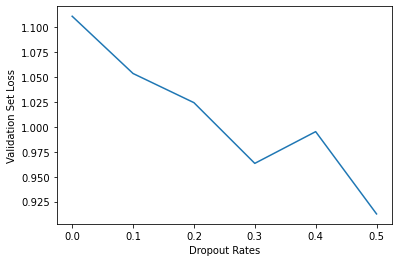

In [25]:
plt.figure()
plt.plot(dropout_rates, test_losses)
plt.xlabel('Dropout Rates')
plt.ylabel('Validation Set Loss')
plt.show()

**So the best dropout rate with the least error amount at the end of 20 epochs seems to be 0.3**

## Learning curve experiment

In [51]:
# Create subsets of the CIFAR-10 dataset with varying sizes
trainset_sizes = [1000, 2000, 5000, 10000, 20000, 40000, 50000]

test_errors_subset_Linear = []

start = time.time() # Keeping track of how long it takes to train our linear network with dropout
print ('=================================================================================================')
print('                                       Test Error Rate')
print ('=================================================================================================')

for size in trainset_sizes:
    trainset_subset = torch.utils.data.Subset(cifar_trainset, torch.arange(size))
    trainloader_subset = torch.utils.data.DataLoader(trainset_subset, batch_size=64, shuffle=True)

    nn1_dropout = SimpleLinearNN_With_Dropout(dropout_rate=0.3) # Since the best dropout rate was found to be 0.3
    optimizer1_dropout = optim.RMSprop(nn1_dropout.parameters(), lr=0.0001)

    test_errors_dropout = []
    print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print ('                                   Trainset Size: ',size)
    print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    
    for epoch in range(20):
        # Training loop
        nn1_dropout.train()
        current_loss = 0.0
        n_mini_batches = 0
        for i, mini_batch in enumerate(trainloader_subset, 0):
            images, labels = mini_batch

            optimizer1_dropout.zero_grad()

            outputs = nn1_dropout(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer1_dropout.step()

            n_mini_batches += 1
            current_loss += loss.item()

        avg_loss = current_loss / n_mini_batches

        # Validation loop
        nn1_dropout.eval()
        current_loss = 0.0
        n_mini_batches = 0
        n_correct = 0
        n_total = 0
        for i, mini_batch in enumerate(testloader, 0):
            images, labels = mini_batch

            outputs = nn1_dropout(images)
            loss = loss_function(outputs, labels)

            # Compute number of correct predictions
            predictions = torch.argmax(outputs, dim=1)
            n_correct += torch.sum(predictions == labels).item()
            n_total += labels.shape[0]

            n_mini_batches += 1
            current_loss += loss.item()

        error_rate = 1 - n_correct / n_total

        if epoch == 19:
            test_errors_dropout.append(error_rate)

        avg_loss = current_loss / n_mini_batches

        print('Epoch %d || Val error rate: %.3f' %(epoch+1, error_rate))
        print('-------------------------------------------------------------------------------------------------')

    test_errors_subset_Linear.append(test_errors_dropout)
    
end = time.time()
print ('=================================================================================================')
exec_time = end - start 
print('Total Time Taken to Train and Test Linear Model with dropout on 20 Epochs : %.2f' %exec_time)
print ('=================================================================================================')


                                       Test Error Rate
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                   Trainset Size:  1000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1 || Val error rate: 0.882
-------------------------------------------------------------------------------------------------
Epoch 2 || Val error rate: 0.878
-------------------------------------------------------------------------------------------------
Epoch 3 || Val error rate: 0.855
-------------------------------------------------------------------------------------------------
Epoch 4 || Val error rate: 0.804
-------------------------------------------------------------------------------------------------
Epoch 5 || Val error rate: 0.816
-------------------------------------------------------------------------------------------------
Epoch 6 || Val error rate: 0.799
-----

Epoch 16 || Val error rate: 0.668
-------------------------------------------------------------------------------------------------
Epoch 17 || Val error rate: 0.681
-------------------------------------------------------------------------------------------------
Epoch 18 || Val error rate: 0.677
-------------------------------------------------------------------------------------------------
Epoch 19 || Val error rate: 0.670
-------------------------------------------------------------------------------------------------
Epoch 20 || Val error rate: 0.700
-------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                   Trainset Size:  10000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1 || Val error rate: 0.788
------------------------------------------------------

Epoch 13 || Val error rate: 0.536
-------------------------------------------------------------------------------------------------
Epoch 14 || Val error rate: 0.541
-------------------------------------------------------------------------------------------------
Epoch 15 || Val error rate: 0.526
-------------------------------------------------------------------------------------------------
Epoch 16 || Val error rate: 0.533
-------------------------------------------------------------------------------------------------
Epoch 17 || Val error rate: 0.521
-------------------------------------------------------------------------------------------------
Epoch 18 || Val error rate: 0.510
-------------------------------------------------------------------------------------------------
Epoch 19 || Val error rate: 0.511
-------------------------------------------------------------------------------------------------
Epoch 20 || Val error rate: 0.503
------------------------------------------

In [47]:
# Create subsets of the CIFAR-10 dataset with varying sizes
trainset_sizes = [1000, 2000, 5000, 10000, 20000, 40000, 50000]

test_errors_subset_CNN = []

start = time.time() # Keeping track of how long it takes to train our linear network with dropout
print ('=================================================================================================')
print('                                       Test Error Rate')
print ('=================================================================================================')

for size in trainset_sizes:
    trainset_subset = torch.utils.data.Subset(cifar_trainset, torch.arange(size))
    trainloader_subset = torch.utils.data.DataLoader(trainset_subset, batch_size=64, shuffle=True)

    nn1_dropout = CNN(dropout_rate=0.3) # Since the best dropout rate was found to be 0.3
    optimizer1_dropout = optim.RMSprop(nn1_dropout.parameters(), lr=0.0001)

    test_errors_dropout = []
    print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print ('                                   Trainset Size: ',size)
    print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    
    for epoch in range(20):
        # Training loop
        nn1_dropout.train()
        current_loss = 0.0
        n_mini_batches = 0
        for i, mini_batch in enumerate(trainloader_subset, 0):
            images, labels = mini_batch

            optimizer1_dropout.zero_grad()

            outputs = nn1_dropout(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer1_dropout.step()

            n_mini_batches += 1
            current_loss += loss.item()

        avg_loss = current_loss / n_mini_batches

        # Validation loop
        nn1_dropout.eval()
        current_loss = 0.0
        n_mini_batches = 0
        n_correct = 0
        n_total = 0
        for i, mini_batch in enumerate(testloader, 0):
            images, labels = mini_batch

            outputs = nn1_dropout(images)
            loss = loss_function(outputs, labels)

            # Compute number of correct predictions
            predictions = torch.argmax(outputs, dim=1)
            n_correct += torch.sum(predictions == labels).item()
            n_total += labels.shape[0]

            n_mini_batches += 1
            current_loss += loss.item()

        error_rate = 1 - n_correct / n_total

        if epoch == 19:
            test_errors_dropout.append(error_rate)

        avg_loss = current_loss / n_mini_batches

        print('Epoch %d || Val error rate: %.3f' %(epoch+1, error_rate))
        print('-------------------------------------------------------------------------------------------------')
    
    
    test_errors_subset_CNN.append(test_errors_dropout)
end = time.time()
print ('=================================================================================================')
exec_time = end - start 
print('Total Time Taken to Train and Test Linear Model with dropout on 20 Epochs : %.2f' %exec_time)
print ('=================================================================================================')


                                       Test Error Rate
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                   Trainset Size:  1000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1 || Val error rate: 0.878
-------------------------------------------------------------------------------------------------
Epoch 2 || Val error rate: 0.841
-------------------------------------------------------------------------------------------------
Epoch 3 || Val error rate: 0.718
-------------------------------------------------------------------------------------------------
Epoch 4 || Val error rate: 0.636
-------------------------------------------------------------------------------------------------
Epoch 5 || Val error rate: 0.579
-------------------------------------------------------------------------------------------------
Epoch 6 || Val error rate: 0.571
-----

Epoch 16 || Val error rate: 0.444
-------------------------------------------------------------------------------------------------
Epoch 17 || Val error rate: 0.524
-------------------------------------------------------------------------------------------------
Epoch 18 || Val error rate: 0.438
-------------------------------------------------------------------------------------------------
Epoch 19 || Val error rate: 0.414
-------------------------------------------------------------------------------------------------
Epoch 20 || Val error rate: 0.454
-------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                   Trainset Size:  10000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1 || Val error rate: 0.584
------------------------------------------------------

Epoch 13 || Val error rate: 0.261
-------------------------------------------------------------------------------------------------
Epoch 14 || Val error rate: 0.253
-------------------------------------------------------------------------------------------------
Epoch 15 || Val error rate: 0.263
-------------------------------------------------------------------------------------------------
Epoch 16 || Val error rate: 0.259
-------------------------------------------------------------------------------------------------
Epoch 17 || Val error rate: 0.257
-------------------------------------------------------------------------------------------------
Epoch 18 || Val error rate: 0.259
-------------------------------------------------------------------------------------------------
Epoch 19 || Val error rate: 0.248
-------------------------------------------------------------------------------------------------
Epoch 20 || Val error rate: 0.278
------------------------------------------

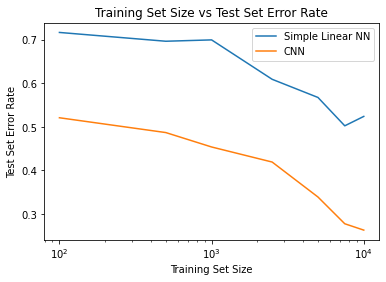

In [53]:
plt.figure()
plt.plot(train_sizes, test_errors_subset_Linear, label='Simple Linear NN')
plt.plot(train_sizes, test_errors_subset_CNN, label='CNN')
plt.xlabel('Training Set Size')
plt.ylabel('Test Set Error Rate')
plt.xscale('log')
plt.legend()
plt.title ('Training Set Size vs Test Set Error Rate')
plt.show()

From the above plot it is clearly visible that the **error rate reduction for CNN is much more rapid** as compared to the Simple Linear Neural Network.

In [54]:
test_errors_subset_CNN

[[0.5211],
 [0.4871],
 [0.45399999999999996],
 [0.4194],
 [0.33909999999999996],
 [0.27769999999999995],
 [0.2631]]

In [55]:
# define the train sizes and test errors
train_sizes = [1000, 2000, 5000, 10000, 20000, 40000, 50000]
test_errors = [0.5211, 0.4871, 0.45399999999999996, 0.4194, 0.33909999999999996, 0.27769999999999995, 0.2631]

# convert to numpy arrays
train_sizes = np.array(train_sizes).reshape(-1, 1)
test_errors = np.array(test_errors)

# use log of train sizes and test errors
log_train_sizes = np.log10(train_sizes)
log_test_errors = np.log10(1 - test_errors)

# fit a linear regression model
model = LinearRegression()
model.fit(log_train_sizes, log_test_errors)

# extract the slope from the model
slope = model.coef_[0]

print("Slope:", slope)

Slope: 0.11241823145841298


As already mentioned before, the **slope of the fitted line corresponds to the power of the relationship between the training set size and test accuracy**. If the slope is **negative, it indicates that the network performance improves as the training set size increases.**

The **absolute value of the slope will give you the power by which the performance improves as a function of the training set size. For example, if the slope is -0.5, it indicates that the error rate (100 - test accuracy) is proportional to 1/sqrt(n), where n is the training set size.**

From our calculation, the slope produced by our CNN model is : **0.11241823145841298**. So, our model improves in regards to error rate by a power of almost 0.112 of the dataset size, so since the slope value is lower, the model converges more rapidly as compared to the Linear Model Used in Q1, Q2 and Q3.